In [1]:
import re
import os
import datetime
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import defaultdict, Counter

In [2]:
results_dirs = ['../thesis-university-impl/results/simulation_2023-05-17 15:58:22',
                '../thesis-university-impl/results/simulation_2023-05-17 16:50:54',
                '../thesis-university-impl/results/simulation_2023-05-17 17:02:55',
                '../thesis-university-impl/results/simulation_2023-05-17 17:26:54',
                '../thesis-university-impl/results/simulation_2023-05-17 17:30:26']

In [3]:
metadata_path = '/meta.csv'
traces_path = '/traces.txt'

In [4]:
actions = ["Inactive","Walking", "PlayingGame", "Eating", "DrinkingCoffee", 
           "Studying", "Working", "WaitingLecture", "AttendingLecture", "GivingLecture"]

In [5]:
def sample_time_to_real(sample_time):
    return (10*sample_time) / (60*60)

In [6]:
def parse_behavioral_traces(file_path):
    traces = []
    
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            trace = []
            matches = re.findall(r'\[([\w\d]+)\(([\w\d\s.,]*)\)](\d+)', line)

            start_time = 0
            for match in matches:
                action_name = match[0]
                components = match[1].split(',') if match[1] else []
                duration = int(match[2])
                
                end_time = start_time + duration - 1
                action = {
                    'name': action_name,
                    'components': components,
                    'duration': duration,
                    'start': start_time,
                    'end': end_time
                }
                
                trace.append(action)
                start_time = end_time + 1
            
            traces.append(trace)
    
    return traces

In [7]:
# Read data 
metadata = pd.DataFrame([])
traces = []

for results in results_dirs:
    meta = pd.read_csv(results + metadata_path)
    tcs = parse_behavioral_traces(results + traces_path)
    
    metadata = pd.concat([metadata, meta], ignore_index=True)
    traces.extend(tcs)

In [8]:
# New dataframe to contain duration of each action
new_metadata = pd.DataFrame.copy(metadata)
for action in actions:
    new_metadata[action] = 0
new_metadata['total_time_active'] = 0
new_metadata.at['sequence_length'] = 0

In [9]:
# Calculate duration for each action 
for i in range(0, len(traces)):
    for action in traces[i]:
        action_name = action['name']
        duration = action['duration']
        
        new_metadata.at[i, action_name] += duration
        new_metadata.at[i, 'total_time_active'] += duration if action_name != "Inactive" else 0
    new_metadata.at[i, 'sequence_length'] = len(traces[i])

In [10]:
new_metadata[:5]

,id,type,driven,workaholic,Inactive,Walking,PlayingGame,Eating,DrinkingCoffee,Studying,Working,WaitingLecture,AttendingLecture,GivingLecture,total_time_active,sequence_length
0,0.0,student,-0.444463,0.0,3729.0,121.0,0.0,0.0,0.0,173.0,0.0,0.0,0.0,0.0,294.0,6.0
1,1.0,student,0.381492,0.0,4856.0,136.0,0.0,0.0,0.0,82.0,0.0,77.0,720.0,0.0,1015.0,8.0
2,2.0,student,0.586871,0.0,3872.0,537.0,0.0,0.0,0.0,219.0,0.0,84.0,720.0,0.0,1560.0,52.0
3,3.0,student,0.080183,0.0,3701.0,1335.0,46.0,21.0,24.0,0.0,0.0,99.0,1440.0,0.0,2965.0,169.0
4,4.0,student,-0.673121,0.0,3706.0,666.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,683.0,37.0


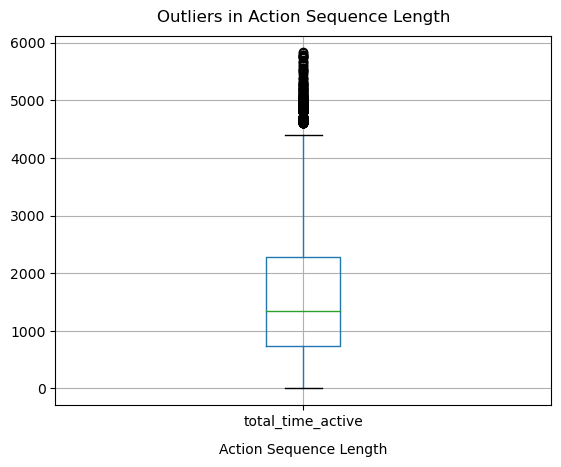

In [11]:
# Visual Detection for outliers
plt.figure()
p = new_metadata.boxplot(column='total_time_active', return_type='axes')
p.set_title('Outliers in Action Sequence Length', pad=10)
p.set_xlabel('Action Sequence Length', labelpad=10)
plt.show()

In [12]:
def determine_outlier_thresholds_iqr(dataframe, col_name, th1=0.25, th3=0.75):
    quartile1 = dataframe[col_name].quantile(th1)
    quartile3 = dataframe[col_name].quantile(th3)
    iqr = quartile3 - quartile1
    upper_limit = quartile3 + 1.5 * iqr
    lower_limit = quartile1 - 1.5 * iqr
    return lower_limit, upper_limit

In [13]:
lower, upper = determine_outlier_thresholds_iqr(new_metadata, 'total_time_active')
lower, upper

(-1588.0, 4596.0)

In [14]:
metadata_no_outliers = new_metadata[new_metadata['total_time_active'] > 1]
metadata_no_outliers = metadata_no_outliers[metadata_no_outliers['total_time_active'] < upper]
len(metadata_no_outliers)

4239

In [15]:
new_metadata['total_time_active'].describe()

count    5001.000000
mean     1827.528694
std      1509.835687
min         0.000000
25%       731.000000
50%      1347.000000
75%      2277.000000
max      5831.000000
Name: total_time_active, dtype: float64

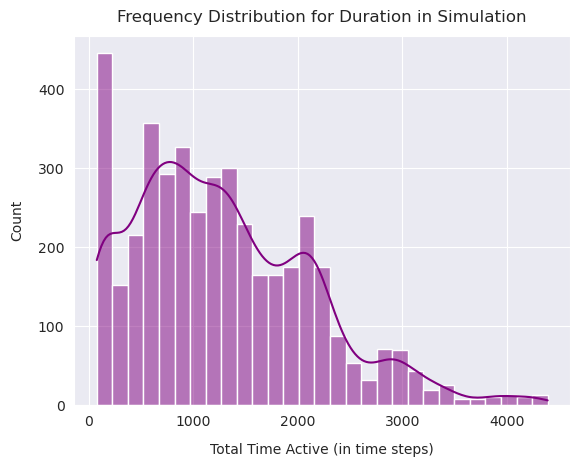

In [16]:
# Calculating action sequence length
sns.set_style("darkgrid")
sns.histplot(data=metadata_no_outliers, x='total_time_active', kde=True, color='purple')
plt.ylabel('Count', labelpad=10)
plt.xlabel('Total Time Active (in time steps)',  labelpad=10)
plt.title('Frequency Distribution for Duration in Simulation',  pad=10)
plt.savefig('duration_action.png', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
students_metadata = new_metadata[new_metadata['type'] == 'student'].copy()
admin_metadata = new_metadata[new_metadata['type'] != 'student'].copy()
admin_metadata = admin_metadata[admin_metadata['GivingLecture'] == 0].reset_index()
professors_metadata = new_metadata[new_metadata['GivingLecture'] > 0].copy()

In [18]:
new_actions = ["Walking", "PlayingGame", "Eating", "DrinkingCoffee", 
           "Studying", "WaitingLecture", "AttendingLecture"]

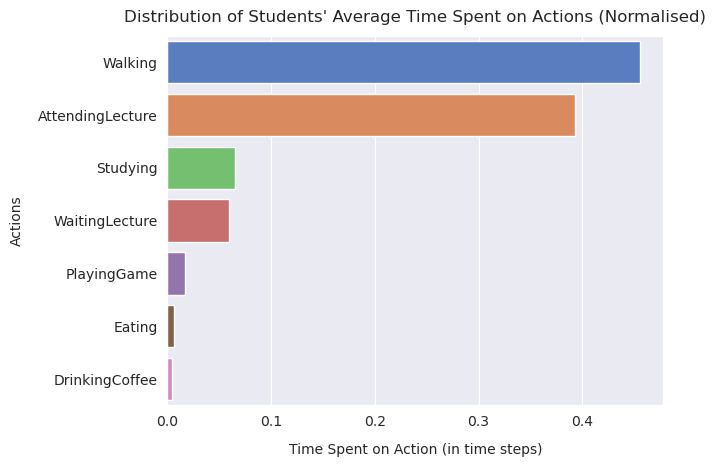

In [19]:
df_normalized = students_metadata[new_actions].div(students_metadata['total_time_active'], axis=0)
average_times = df_normalized[new_actions].mean()
average_times = average_times.sort_values(ascending=False)

sns.set_style("darkgrid")
sns.set_palette("muted")
sns.barplot(x=average_times, y=average_times.keys())

# Set the labels and title
plt.xlabel('Time Spent on Action (in time steps)', labelpad=10)
plt.ylabel('Actions', labelpad=10)
plt.title("Distribution of Students' Average Time Spent on Actions (Normalised)", pad=10)
plt.savefig('dist_actions_stud.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
new_actions = ["Walking", "PlayingGame", "Eating", "DrinkingCoffee", 
           "Working", "WaitingLecture", "GivingLecture"]

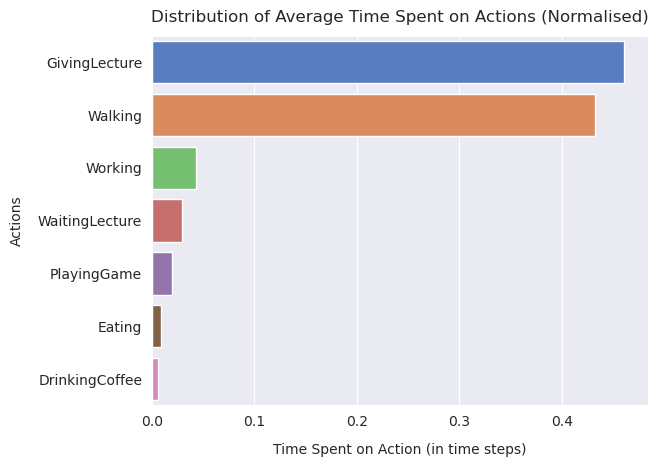

In [21]:
df_normalized = professors_metadata[new_actions].div(professors_metadata['total_time_active'], axis=0)
average_times = df_normalized[new_actions].mean()
average_times = average_times.sort_values(ascending=False)

sns.set_style("darkgrid")
sns.set_palette("muted")
sns.barplot(x=average_times, y=average_times.keys())

# Set the labels and title
plt.xlabel('Time Spent on Action (in time steps)', labelpad=10)
plt.ylabel('Actions', labelpad=10)
plt.title('Distribution of Average Time Spent on Actions (Normalised)', pad=10)
plt.savefig('dist_actions_prof.png', dpi=300, bbox_inches='tight')
plt.show()

In [22]:
new_actions = ["Walking", "PlayingGame", "Eating", "DrinkingCoffee", "Working"]

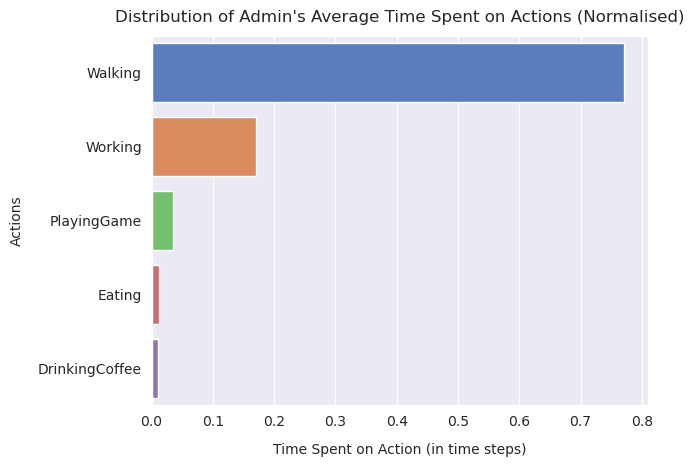

In [23]:
df_normalized = admin_metadata[new_actions].div(admin_metadata['total_time_active'], axis=0)
average_times = df_normalized[new_actions].mean()
average_times = average_times.sort_values(ascending=False)

sns.set_style("darkgrid")
sns.set_palette("muted")
sns.barplot(x=average_times, y=average_times.keys())

# Set the labels and title
plt.xlabel('Time Spent on Action (in time steps)', labelpad=10)
plt.ylabel('Actions', labelpad=10)
plt.title("Distribution of Admin's Average Time Spent on Actions (Normalised)", pad=10)
plt.savefig('dist_actions_admin.png', dpi=300, bbox_inches='tight')
plt.show()

In [24]:
students_metadata[actions] = students_metadata[actions].applymap(sample_time_to_real)
admin_metadata[actions] = admin_metadata[actions].applymap(sample_time_to_real)
professors_metadata[actions] = professors_metadata[actions].applymap(sample_time_to_real)

In [25]:
students_metadata.describe()

,id,driven,workaholic,Inactive,Walking,PlayingGame,Eating,DrinkingCoffee,Studying,Working,WaitingLecture,AttendingLecture,GivingLecture,total_time_active,sequence_length
count,3000.000000,3000.000000,3000.0,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.0,3000.000000,3000.000000,3000.0,3000.000000,3000.000000
mean,299.500000,0.006975,0.0,11.592758,2.482602,0.096159,0.039896,0.030694,0.201762,0.0,0.220841,1.816280,0.0,1759.764333,112.562667
std,173.233715,0.483382,0.0,1.813990,3.135105,0.104764,0.056723,0.041103,0.407306,0.0,0.220346,1.425079,0.0,1132.415223,114.088156
min,0.000000,-1.000000,0.0,7.719444,0.219444,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,79.000000,3.000000
25%,149.750000,-0.326384,0.0,10.360417,0.565972,0.000000,0.000000,0.000000,0.000000,0.0,0.019444,0.000000,0.0,953.750000,16.000000
50%,299.500000,-0.002819,0.0,10.822222,1.458333,0.086111,0.000000,0.000000,0.000000,0.0,0.169444,2.000000,0.0,1537.500000,79.000000
75%,449.250000,0.349253,0.0,12.105556,3.064583,0.113889,0.108333,0.066667,0.191667,0.0,0.350000,2.000000,0.0,2191.250000,171.000000
max,599.000000,1.000000,0.0,17.927778,15.122222,0.463889,0.244444,0.133333,3.138889,0.0,1.213889,6.000000,0.0,5818.000000,498.000000


In [26]:
professors_metadata.describe()

,id,driven,workaholic,Inactive,Walking,PlayingGame,Eating,DrinkingCoffee,Studying,Working,WaitingLecture,AttendingLecture,GivingLecture,total_time_active,sequence_length
count,38.000000,38.0,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.0,38.000000,38.000000,38.0,38.000000,38.000000,38.000000
mean,604.657895,0.0,0.208691,10.717909,2.807091,0.112427,0.055994,0.038816,0.0,0.167471,0.130556,0.0,1.997515,1911.552632,141.500000
std,3.164638,0.0,0.392296,0.259177,2.599344,0.082336,0.056414,0.035652,0.0,0.266736,0.090327,0.0,0.015046,950.026591,97.150969
min,600.000000,0.0,-0.510555,10.288889,0.308333,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1.938889,822.000000,5.000000
25%,601.250000,0.0,-0.071598,10.380556,0.831944,0.075000,0.000000,0.000000,0.0,0.000000,0.075000,0.0,2.002778,1181.750000,65.000000
50%,605.000000,0.0,0.226448,10.837500,1.658333,0.111111,0.055556,0.066667,0.0,0.000000,0.134722,0.0,2.002778,1562.500000,143.500000
75%,607.000000,0.0,0.506154,10.913889,4.679167,0.150694,0.111111,0.066667,0.0,0.221528,0.177083,0.0,2.002778,2538.000000,205.750000
max,609.000000,0.0,0.805521,10.986111,8.538889,0.277778,0.119444,0.083333,0.0,1.194444,0.311111,0.0,2.002778,3984.000000,316.000000


In [27]:
admin_metadata.describe()

,id,driven,workaholic,Inactive,Walking,PlayingGame,Eating,DrinkingCoffee,Studying,Working,WaitingLecture,AttendingLecture,GivingLecture,total_time_active,sequence_length
count,1963.000000,1963.0,1963.000000,1963.000000,1963.000000,1963.000000,1963.000000,1963.000000,1963.0,1963.000000,1963.0,1963.0,1963.0,1963.000000,1962.000000
mean,802.864493,0.0,0.003394,10.508614,4.608693,0.193092,0.070780,0.063340,0.0,0.423719,0.0,0.0,0.0,1929.464595,212.971458
std,114.762748,0.0,0.480639,0.462628,5.382975,0.171072,0.075054,0.060372,0.0,0.658029,0.0,0.0,0.0,1953.116723,184.043199
min,0.000000,0.0,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,3.000000
25%,705.000000,0.0,-0.336047,10.313889,0.554167,0.050000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,491.000000,41.000000
50%,803.000000,0.0,0.000960,10.408333,1.611111,0.119444,0.052778,0.066667,0.0,0.000000,0.0,0.0,0.0,910.000000,168.000000
75%,901.000000,0.0,0.342955,10.819444,12.275000,0.408333,0.122222,0.133333,0.0,0.750000,0.0,0.0,0.0,4662.000000,431.000000
max,999.000000,0.0,1.000000,11.013889,15.461111,0.486111,0.341667,0.238889,0.0,3.611111,0.0,0.0,0.0,5831.000000,572.000000
